## Import the package and data

In [1]:
import numpy as np
import pandas as pd
import math
import torch
import matplotlib.pyplot  as plt
import matplotlib
import copy

from random import shuffle
from torch.utils.data import DataLoader, TensorDataset, random_split, Dataset,ConcatDataset
from torch import nn
from torchvision import datasets,transforms
from scipy.stats import chi2
from mpl_toolkits.mplot3d import Axes3D
from DML_COX import *
from lifelines import CoxPHFitter
def toPandas(data):
    return  pd.DataFrame(torch.cat([data.T.cpu(), data.D.cpu(),data.X.cpu(),data.Z.cpu()],1))   


torch.cuda.empty_cache()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [2]:
# 读取CSV文件
rotterdam = pd.read_csv('rotterdam.csv')

# 显示数据的前几行
print(rotterdam.head())
T = torch.unsqueeze(torch.tensor(rotterdam.dtime),1).to(torch.float32)
D = torch.unsqueeze(torch.tensor(rotterdam.death),1).to(torch.float32)
X1 = torch.unsqueeze(torch.tensor(rotterdam.hormon),1).to(torch.float32)
X2 = torch.unsqueeze(torch.tensor(rotterdam.chemo),1).to(torch.float32)
X = torch.cat((X1,X2),1)
# print(T.shape)
# print(D.shape)
# print(X.shape)

   Unnamed: 0  pid  year  age  meno   size  grade  nodes  pgr   er  hormon  \
0        1393    1  1992   74     1   <=20      3      0   35  291       0   
1        1416    2  1984   79     1  20-50      3      0   36  611       0   
2        2962    3  1983   44     0   <=20      2      0  138    0       0   
3        1455    4  1985   70     1  20-50      3      0    0   12       0   
4         977    5  1983   75     1   <=20      3      0  260  409       0   

   chemo  rtime  recur  dtime  death  
0      0   1799      0   1799      0  
1      0   2828      0   2828      0  
2      0   6012      0   6012      0  
3      0   2624      0   2624      0  
4      0   4915      0   4915      0  


In [3]:
# year = torch.tensor(rotterdam['year']).reshape(-1,1).to(torch.float32)
age = torch.tensor(rotterdam['age']).reshape(-1,1).to(torch.float32)
# age = age-torch.mean(age)
meno = torch.tensor(rotterdam['meno']).reshape(-1,1).to(torch.float32)
nodes = torch.tensor(rotterdam['nodes']).reshape(-1,1).to(torch.float32)
pgr = torch.tensor(rotterdam['pgr']).reshape(-1,1).to(torch.float32)
er = torch.tensor(rotterdam['er']).reshape(-1,1).to(torch.float32)
recur = torch.tensor(rotterdam['recur']).reshape(-1,1).to(torch.float32)
Z = torch.cat((age, meno, nodes, pgr, er, recur),axis=1)
# print(Z)
Z_size = torch.tensor(np.array(pd.get_dummies(rotterdam['size']))).to(torch.float32)[:,0:2]
Z_grade = torch.unsqueeze(torch.tensor(np.array(pd.get_dummies(rotterdam['grade']))).to(torch.float32)[:,0],1)
Z = feature_normalize(torch.cat((Z,Z_size,Z_grade),axis=1))
# print(Z)
mydat = DeepSurvData(T,D,X,Z,device)
print(mydat.Z.shape)

torch.Size([2982, 9])


In [4]:
np.random.seed(2024)
torch.manual_seed(1)
sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:2400]
sample2 = sample[2400:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]
print(mydat_train.Z.shape)


model_theta = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(mydat.Z.shape[1],50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,mydat.X.shape[1]),
    nn.Sigmoid(),
)


Epoch_XZ=1181
lr_XZ=5e-2
Epoch_theta=1191
lr_theta=1e-3


torch.Size([2400, 9])


## Estimating $\theta(Z)$, $\Lambda(t)$

In [5]:
# beta_est,theta_est = fit_CoxPH(mydat_train,device=device,model=model_theta,
#                                Epoch=Epoch_theta, lr=lr_theta,
#                                Test_set=mydat_test,print_state=True)
# print(beta_est)
torch.manual_seed(1)
T_interval = torch.quantile(mydat.T,torch.arange(0,0.9,0.2).to(device))
print('train E[X|Z,T>t]')
model_XZ_fit = fit_XZ_complete(mydat_train,T_interval=T_interval,device=device,loss_fn=nn.BCELoss(),
                           model=model_XZ, lr=lr_XZ, Epoch=Epoch_XZ,
                           Test_set=mydat_test,print_state=True)


train E[X|Z,T>t]
epoch: 0 Train_loss:3.52642, epoch: 0 Test_loss:2.01339
epoch: 10 Train_loss:1.33843, epoch: 10 Test_loss:1.43259
epoch: 20 Train_loss:0.93752, epoch: 20 Test_loss:1.13080
epoch: 30 Train_loss:0.71318, epoch: 30 Test_loss:1.00078
epoch: 40 Train_loss:0.62017, epoch: 40 Test_loss:1.15761
epoch: 50 Train_loss:0.55155, epoch: 50 Test_loss:1.33020


## Double Robust Estimation

In [7]:
torch.manual_seed(1)
model_theta = nn.Sequential(
    nn.Linear(9,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,1),
)

# model_theta = nn.Sequential(
#     nn.Linear(9,100),
#     nn.ReLU(),
#     nn.Linear(100,100),
#     nn.ReLU(),
#     nn.Linear(100,1),
# )

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(9,100),
    nn.ReLU(),
    nn.Linear(100,100),
    nn.ReLU(),
    nn.Linear(100,2),
    nn.Sigmoid(),
)


Epoch_XZ=201
lr_XZ=1e-2
Epoch_theta=201
lr_theta=1e-2
accuracy=0.1

In [8]:
np.random.seed(2024)
torch.manual_seed(1)

sample=np.random.permutation(np.arange(len(mydat.T)))
sample1 = sample[0:2400]
sample2 = sample[2400:len(sample)]
mydat_train = mydat[sample1] 
mydat_test = mydat[sample2]

# train the double robust model
(beta_DB, var_est_DB, 
 beta_est1, deepSurv1,  model_XZ1, 
 beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=0.2, Early_stop=True,
                                              Test_set= mydat_test,loss_XZ=nn.BCELoss(),
                                              model_XZ=model_XZ, model_theta=model_theta,
                                              Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                              lr_XZ=lr_XZ, lr_theta=lr_theta,
                                              print_state=True)

beta=torch.zeros(2)
net = CustomNet(h_dims=[1, 50,50,50, len(beta)], g_dims=[9,50,50,50, len(beta)])
var_est_naive = fit_variance(mydat_train, net, device=device, lr=5e-4,print_state=True)

# calculate the direct parameter estimator without using double robust techniques
beta_naive=(beta_est1+beta_est2)/2
# calculate the p_value
beta=beta.to(device)



train theta(Z)
epoch: 0 Train_loss:3.08761, epoch: 0 Test_loss:2.53926
epoch: 10 Train_loss:2.85329, epoch: 10 Test_loss:2.35798
epoch: 20 Train_loss:2.80774, epoch: 20 Test_loss:2.32651
epoch: 30 Train_loss:2.79039, epoch: 30 Test_loss:2.33041
epoch: 40 Train_loss:2.77701, epoch: 40 Test_loss:2.33476
epoch: 50 Train_loss:2.76605, epoch: 50 Test_loss:2.34416
train E[X|Z,T>t]
epoch: 0 Train_loss:3.38014, epoch: 0 Test_loss:2.59095
epoch: 10 Train_loss:1.59582, epoch: 10 Test_loss:1.70738
epoch: 20 Train_loss:1.36673, epoch: 20 Test_loss:1.48407
epoch: 30 Train_loss:1.20087, epoch: 30 Test_loss:1.37674
epoch: 40 Train_loss:1.01235, epoch: 40 Test_loss:1.19211
epoch: 50 Train_loss:0.83570, epoch: 50 Test_loss:1.03595
epoch: 60 Train_loss:0.71668, epoch: 60 Test_loss:0.99768
epoch: 70 Train_loss:0.65223, epoch: 70 Test_loss:1.03020
train theta(Z)
epoch: 0 Train_loss:3.08429, epoch: 0 Test_loss:2.53646
epoch: 10 Train_loss:2.85358, epoch: 10 Test_loss:2.35559
epoch: 20 Train_loss:2.80995, e

In [9]:
# var_est_naive=var_est_naive.to(device)
print()
chi_value = torch.squeeze((beta_naive-beta) @ torch.inverse(var_est_naive) @ torch.unsqueeze(beta_naive-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_naive))
p_value_single = 1 - chi2.cdf(((beta_naive-beta)**2/torch.diag(var_est_naive)).cpu(),1)
print('PL Cox bias：',beta_naive-beta,'bias norm:',torch.norm(beta_naive-beta))
print('PL Cox standard error：',torch.sqrt(torch.diag(var_est_naive)))
print('PL Cox test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_naive)):
    print('PL Cox test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


print()
chi_value = torch.squeeze((beta_DB-beta) @ torch.inverse(var_est_DB) @ torch.unsqueeze(beta_DB-beta,1))
p_value_joint = 1 - chi2.cdf(chi_value.cpu(),len(beta_DB))
p_value_single = 1 - chi2.cdf(((beta_DB-beta)**2/torch.diag(var_est_DB)).cpu(),1)
print('DBPL bias：',beta_DB-beta,'DBPL bias：',torch.norm(beta_DB-beta))
print('DBPL standard error：',torch.sqrt(torch.diag(var_est_DB)))
print('DBPL test H_0: β=β_0, p value：%.5f'%p_value_joint)
for i in range(len(beta_DB)):
    print('DBPL test H_0: β[%d]=β_0[%d], p value：%.5f'%(i,i,p_value_single[i]))


PL Cox bias： tensor([-0.2029, -0.3033], device='cuda:0') bias norm: tensor(0.3649, device='cuda:0')
PL Cox standard error： tensor([0.1106, 0.1282], device='cuda:0')
PL Cox test H_0: β=β_0, p value：0.01621
PL Cox test H_0: β[0]=β_0[0], p value：0.06669
PL Cox test H_0: β[1]=β_0[1], p value：0.01797

DBPL bias： tensor([-0.1766, -0.2601], device='cuda:0') DBPL bias： tensor(0.3144, device='cuda:0')
DBPL standard error： tensor([0.0963, 0.1358], device='cuda:0')
DBPL test H_0: β=β_0, p value：0.03927
DBPL test H_0: β[0]=β_0[0], p value：0.06680
DBPL test H_0: β[1]=β_0[1], p value：0.05547


In [10]:
beta=torch.zeros(2)
net = CustomNet(h_dims=[1, 50,50, len(beta)], g_dims=[9,50,50, len(beta)])
var_est_naive = fit_variance(mydat_train, net, device=device, lr=1e-2,Epoch=400,print_state=True)
print(np.sqrt(np.diag(var_est_naive.cpu())))

Epoch 10, Train Loss: 0.099762, Val Loss: 0.082260
Epoch 20, Train Loss: 0.088221, Val Loss: 0.071309
Epoch 30, Train Loss: 0.082670, Val Loss: 0.070795
Epoch 40, Train Loss: 0.077248, Val Loss: 0.064184
Epoch 50, Train Loss: 0.071726, Val Loss: 0.057589
Epoch 60, Train Loss: 0.066995, Val Loss: 0.054062
Epoch 70, Train Loss: 0.062924, Val Loss: 0.052877
Epoch 80, Train Loss: 0.059366, Val Loss: 0.052345
Epoch 90, Train Loss: 0.056064, Val Loss: 0.053728
[0.11269546 0.13790399]


## Cross validation

In [16]:
torch.manual_seed(2024)

# model_theta = nn.Sequential(
#     nn.Linear(9,1),
# )

# model_theta = nn.Sequential(
#     nn.Linear(9,100),
#     nn.ReLU(),
#     nn.Linear(100,100),
#     nn.ReLU(),
#     nn.Linear(100,1),
# )

# # define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
# model_XZ = nn.Sequential(
#     nn.Linear(9,100),
#     nn.ReLU(),
#     nn.Linear(100,100),
#     nn.ReLU(),
#     nn.Linear(100,2),
#     nn.Sigmoid(),
# )

model_theta = nn.Sequential(
    nn.Linear(9,50),
    nn.ReLU(),
    # nn.Linear(50,50),
    # nn.ReLU(),
    nn.Linear(50,1),
)

# define the neural network framework used to train f(Z,t) = E[X|Z,T>t]
model_XZ = nn.Sequential(
    nn.Linear(9,50),
    nn.ReLU(),
    nn.Linear(50,50),
    nn.ReLU(),
    nn.Linear(50,2),
    nn.Sigmoid(),
)


Epoch_XZ=201
lr_XZ=1e-2
Epoch_theta=201
lr_theta=1e-2
accuracy=0.1

In [17]:
BETA_DB = list()
BETA_NAIVE = list()
BETA_COX = list()

SE_DB = list()
SE_NAIVE = list()
SE_COX = list()

np.random.seed(2024); torch.manual_seed(2024)
sample = np.random.permutation(np.arange(len(mydat.T)))
# Split the vector into 5 random parts
split_vector = np.array_split(sample, 5)
# Print the resulting split vector
for i, sample_val in enumerate(split_vector):
    mask = np.isin(sample, sample_val, invert=True)
    mydat_train = mydat[sample[mask]] 
    mydat_test = mydat[sample_val]
    # train the double robust model
    (beta_DB, var_est_DB, 
     beta_est1, deepSurv1,  model_XZ1, 
     beta_est2, deepSurv2, model_XZ2) = DML_CoxPH(mydat_train, device=device,accuracy=accuracy, Test_set= mydat_test,
                                                  model_XZ=model_XZ, model_theta=model_theta,
                                                  Epoch_XZ=Epoch_XZ, Epoch_theta=Epoch_theta,
                                                  lr_XZ=lr_XZ, lr_theta=lr_theta,
                                                  print_state=False)

    beta=torch.zeros(2)
    beta_naive=(beta_est1+beta_est2)/2
    net = CustomNet(h_dims=[1, 50,50, len(beta)], g_dims=[9,50,50, len(beta)])
    var_est_naive = fit_variance(mydat_train, net, device=device, lr=1e-2,Epoch=300,print_state=False)
    
    cph = CoxPHFitter()
    cph.fit(toPandas(mydat_train), 0, 1)
    # cph.print_summary()
    beta_Cox = np.array(cph.params_[0:2])
    se_Cox = np.sqrt(np.diag(cph.variance_matrix_)[0:2])

    BETA_DB.append(beta_DB.cpu())
    BETA_NAIVE.append(beta_naive.cpu())
    BETA_COX.append(beta_Cox)
    SE_COX.append(se_Cox)
    SE_NAIVE.append(np.sqrt(np.diag(var_est_naive.cpu())))
    SE_DB.append(np.sqrt(np.diag(var_est_DB.cpu())))

    print(i,end=' ')
    pass
    

0 1 2 3 4 

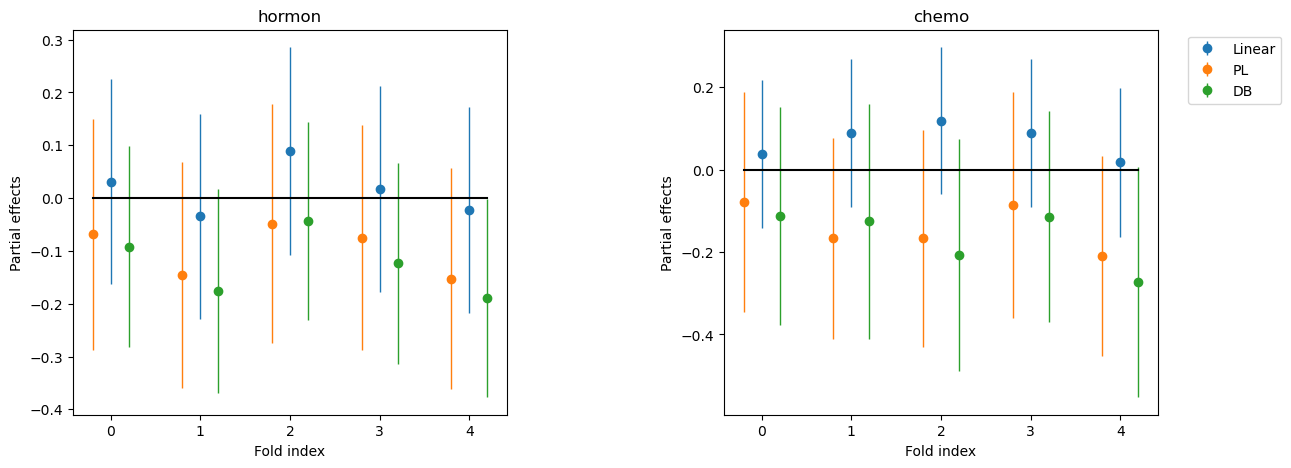

In [22]:
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.errorbar(range(5), np.array(BETA_COX)[:,0],1.96*np.array(SE_COX)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,0],1.96*np.array(SE_NAIVE)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,0],1.96*np.array(SE_DB)[:,0],fmt='o', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
plt.title('hormon')

plt.subplot(1,2,2)
plt.errorbar(range(5), np.array(BETA_COX)[:,1],1.96*np.array(SE_COX)[:,1],fmt='o',label='Linear', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,1],1.96*np.array(SE_NAIVE)[:,1],fmt='o',label='PL', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,1],1.96*np.array(SE_DB)[:,1],fmt='o',label='DB', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
# plt.ylim(-0.6,1)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))

plt.title('chemo')

plt.subplots_adjust(wspace=0.5)
plt.savefig('rotterdam4.pdf')
plt.show()

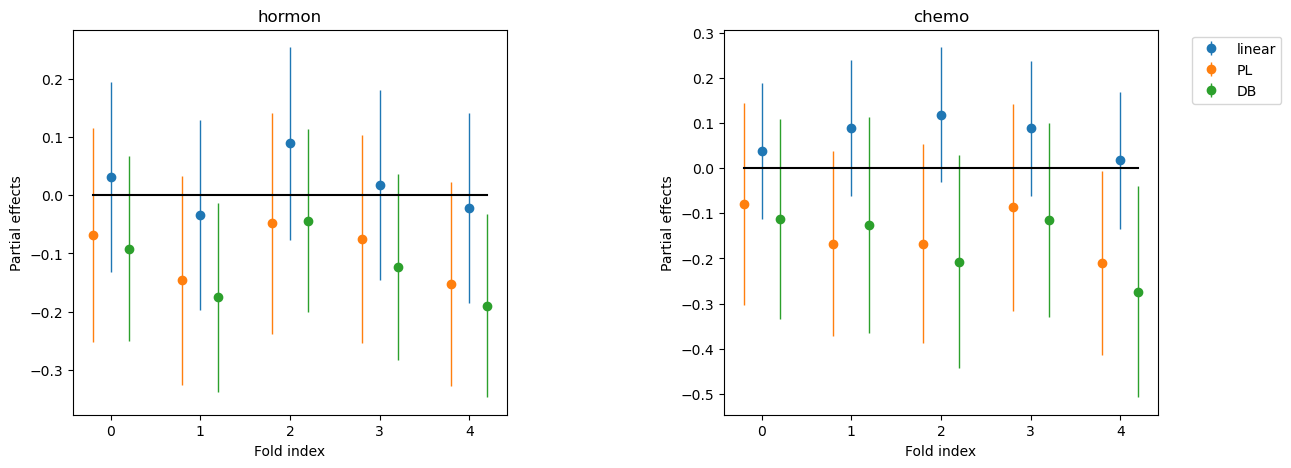

In [27]:
plt.figure(figsize=[14,5])
plt.subplot(1,2,1)
plt.errorbar(range(5), np.array(BETA_COX)[:,0],1.645*np.array(SE_COX)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,0],1.645*np.array(SE_NAIVE)[:,0],fmt='o', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,0],1.645*np.array(SE_DB)[:,0],fmt='o', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
plt.title('hormon')

plt.subplot(1,2,2)
plt.errorbar(range(5), np.array(BETA_COX)[:,1],1.645*np.array(SE_COX)[:,1],fmt='o',label='linear', linewidth=1)
plt.errorbar(np.arange(5)-0.2, np.array(BETA_NAIVE)[:,1],1.645*np.array(SE_NAIVE)[:,1],fmt='o',label='PL', linewidth=1)
plt.errorbar(np.arange(5)+0.2, np.array(BETA_DB)[:,1],1.645*np.array(SE_DB)[:,1],fmt='o',label='DB', linewidth=1)
plt.plot([-0.2,4.2],[0,0],color='black')
plt.xlabel('Fold index')
plt.ylabel('Partial effects')
# plt.ylim(-0.6,1)
plt.legend(loc='upper right',bbox_to_anchor=(1.3, 1))

plt.title('chemo')

plt.subplots_adjust(wspace=0.5)
plt.savefig('rotterdam3.pdf')
plt.show()